# PMI Demo Analysis

This is a demonstration of a data analysis pipeline using a Jupyter notebook with simulated PMI data. The notebook is a dynamic, interactive data analysis environment where Python, R or other analytic code can be combined with descriptive text and graphics. The entire analysis, from data import to the display of results can be displayed in a single document, which can become a report in either PDF or HTML for distribution.

The notebook demonstrates several things:

- importing data from csv files
- cleaning variables (converting them to numeric formats)
- reshaping tables from long to wide format
- merging two tables into a single table, with one patient per row
- plotting histograms of numeric variables
- imputing missing values
- fitting a decision tree machine learning model to predict fatigue

The analysis demonstrated here will be written in Python, but various languages can be supported by the notebooks.

The cell below is code for importing various libraries from Python, and setting a few preferences.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='viridis')

## Import and clean data

We will use a software package called `pandas` to import, clean, and manipulate the data. It can perform a variety of cleaning, transforming and reshaping tasks in just a few lines of code. 

The cell below imports a dataset containing patient observations that were simulated to represent PPI, and stored as text files. In production, data will likely be imported directly from a PMI data source, but the structure of the data will be similar.

After importing we show the first few lines of data.

In [2]:
observation_data = pd.read_csv('../data/test_etl_6/test_etl_6-observation.csv', 
                               low_memory=False)
observation_data.head()

,observation_id,person_id,observation_concept_id,observation_date,observation_datetime,observation_type_concept_id,value_as_number,value_as_string,value_as_concept_id,qualifier_concept_id,unit_concept_id,provider_id,visit_occurrence_id,observation_source_value,observation_source_concept_id,unit_source_value,qualifier_source_value,value_source_concept_id,value_source_value,questionnaire_response_id
0,1,100011931,0,2012-08-10,2012-08-10 16:42:56,45905771,NaN,Severe,0,0,0,NaN,NaN,OverallHealth_AverageFatigue7Days,1585748,NaN,NaN,1585752,AverageFatigue7Days_Severe,438336969.0
1,2,100011931,0,2012-08-10,2012-08-10 16:42:56,45905771,3.0,NaN,0,0,0,NaN,NaN,OverallHealth_AveragePain7Days,1585747,NaN,NaN,0,NaN,438336969.0
2,3,100011931,0,2012-08-10,2012-08-10 16:42:56,45905771,NaN,Sometimes,0,0,0,NaN,NaN,OverallHealth_DifficultUnderstandInfo,1585778,NaN,NaN,1585781,DifficultUnderstandInfo_Sometimes,438336969.0
3,4,100011931,0,2012-08-10,2012-08-10 16:42:56,45905771,NaN,Often,0,0,0,NaN,NaN,OverallHealth_EmotionalProblem7Days,1585760,NaN,NaN,1585764,EmotionalProblem7Days_Often,438336969.0
4,5,100011931,0,2012-08-10,2012-08-10 16:42:56,45905771,NaN,A Little,0,0,0,NaN,NaN,OverallHealth_EverydayActivities,1585741,NaN,NaN,1585745,EverydayActivities_ALittle,438336969.0


We can display properties of the dataset, such as its shape. The two numbers below show the number of rows and columns in the table; there are well **over a million rows** of simulated data here.

In [3]:
observation_data.shape

(1192848, 20)

We can also import a table of *measurements* corresponding to a subset of patients. Further along in the data manipulation pipeline, we can merge these with the previous dataset.

In [4]:
measurement_data = pd.read_csv('../data/test_etl_6/test_etl_6-measurement.csv', 
                               low_memory=False).dropna(subset=['value_source_value'])
measurement_data.head()

,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,unit_concept_id,range_low,range_high,provider_id,visit_occurrence_id,measurement_source_value,measurement_source_concept_id,unit_source_value,value_source_value
0,1,100276412,0,2014-03-05,2014-03-05 21:03:17,44818701,0,66.199997,0,9529,NaN,NaN,NaN,1,pre-pregnancy-weight,0,kg,66.2 - kg
1,2,100276412,3004249,2014-03-05,2014-03-05 21:03:17,44818701,0,136.000000,0,8876,NaN,NaN,NaN,1,8480-6,3004249,mm[Hg],136 - mm[Hg]
2,3,100276412,3012888,2014-03-05,2014-03-05 21:03:17,44818701,0,64.000000,0,8876,NaN,NaN,NaN,1,8462-4,3012888,mm[Hg],64 - mm[Hg]
3,4,100276412,3025315,2014-03-05,2014-03-05 21:03:17,44818701,0,41.099998,0,9529,NaN,NaN,NaN,1,29463-7,3025315,kg,41.1 - kg
4,5,100276412,3027018,2014-03-05,2014-03-05 21:03:17,44818701,0,68.000000,0,8541,NaN,NaN,NaN,1,8867-4,3027018,/min,68 - /min


We can get a quick summary of the different data values in a particular column by calling `value_counts` on it. For example, looking at the `measurement_source_value` column, we can see that it is a mixture of data labels and codes.

In [5]:
measurement_data.measurement_source_value.value_counts()

8302-2                     6803
8867-4                     6768
wheelchair-bound-status    6767
29463-7                    6750
pre-pregnancy-weight       6747
39156-5                    6709
8480-6                     6078
8462-4                     6051
Name: measurement_source_value, dtype: int64

So, we might want to convert codes in measurement table to variable labels, so that they are easy to identify. We first create a *lookup table* for codes and corresponding labels, then use the `replace` method to swap the codes for the lables in the column of data.

In [6]:
code_lookup = {'29463-7':'body_weight',
              '8302-2':'height',
              '8867-4':'heart_rate',
              '55284-4':'blood_pressure',
              '39156-5':'bmi',
              '8480-6':'systolic_bp',
              '8462-4':'diastolic_bp'}

measurement_data['measurement'] = measurement_data.measurement_source_value.replace(code_lookup)

If we look at the `value_counts` now, it is easier to see what the counts represent.

In [7]:
measurement_data.measurement.value_counts()

height                     6803
heart_rate                 6768
wheelchair-bound-status    6767
body_weight                6750
pre-pregnancy-weight       6747
bmi                        6709
systolic_bp                6078
diastolic_bp               6051
Name: measurement, dtype: int64

Data in the measurement table is in **long** format, meaning that there is a row for each measurement, and multiple measurements for each patient. But we require **wide** format for statistical analyses, where there is one row per patient, and various columns of measurements. 

We can *pivot* the variable column by creating a pandas `MultiIndex` and unstacking the last level.

In [8]:
measurements = (measurement_data.set_index(['person_id', 'measurement_date','measurement'])
                .value_source_value
                .unstack(level=-1))

Now look at the table:

In [9]:
measurements.head()

,measurement,bmi,body_weight,diastolic_bp,heart_rate,height,pre-pregnancy-weight,systolic_bp,wheelchair-bound-status
person_id,measurement_date,,,,,,,,
100276412,2014-03-05,418 - kg/m2,41.1 - kg,64 - mm[Hg],68 - /min,150 - cm,66.2 - kg,136 - mm[Hg],wheelchair-bound
100281317,2015-04-13,199 - kg/m2,57.3 - kg,109 - mm[Hg],115 - /min,66.3 - cm,75.5 - kg,98 - mm[Hg],None
100347387,2014-01-18,316.9 - kg/m2,51.1 - kg,103 - mm[Hg],46 - /min,80.5 - cm,100.9 - kg,124 - mm[Hg],wheelchair-bound
100444746,2016-11-28,360.3 - kg/m2,174.9 - kg,120 - mm[Hg],62 - /min,79.5 - cm,57.7 - kg,158 - mm[Hg],wheelchair-bound
100562058,2017-10-03,None,86.6 - kg,52 - mm[Hg],None,63 - cm,87.8 - kg,177 - mm[Hg],wheelchair-bound


However, notice that the values include the units, making then non-numeric. So we need to strip redundant units from numeric value column and cast the digits to floats.

This is an example of a complex data transformation using `pandas`. The following steps are performed all in one line of code:

- split each element in the data cells on the dash (`-`) character
- use an underscore character to represent missing data
- extract the element before the dash in each data item (*i.e.* the numeric value)
- replace the underscores with a missing data value (nan)
- set the data type to a floating-point numeric type

In [10]:
measurements[measurements.columns[:-1]] = (measurements[measurements.columns[:-1]]
                                    .apply(lambda x: x.str.split(' - '))
                                    .fillna('_')
                                    .applymap(lambda x: x[0])
                                    .replace({'_': np.nan})
                                    .astype(float))

Though it may not be obvious why each step was required, you can see below that the data are now indeed numeric, and can be used in a statistical analysis.

In [11]:
measurements.head()

,measurement,bmi,body_weight,diastolic_bp,heart_rate,height,pre-pregnancy-weight,systolic_bp,wheelchair-bound-status
person_id,measurement_date,,,,,,,,
100276412,2014-03-05,418.0,41.1,64.0,68.0,150.0,66.2,136.0,wheelchair-bound
100281317,2015-04-13,199.0,57.3,109.0,115.0,66.3,75.5,98.0,None
100347387,2014-01-18,316.9,51.1,103.0,46.0,80.5,100.9,124.0,wheelchair-bound
100444746,2016-11-28,360.3,174.9,120.0,62.0,79.5,57.7,158.0,wheelchair-bound
100562058,2017-10-03,NaN,86.6,52.0,NaN,63.0,87.8,177.0,wheelchair-bound


Now that we have numeric values, we can perform analyses; for instance, we can plot histograms of the numberic variables. Values are uniformly diastributed for all variables.

This step is performed using another Python package called `seaborn`, which makes it really easy to generate a grid of plots of the same type:

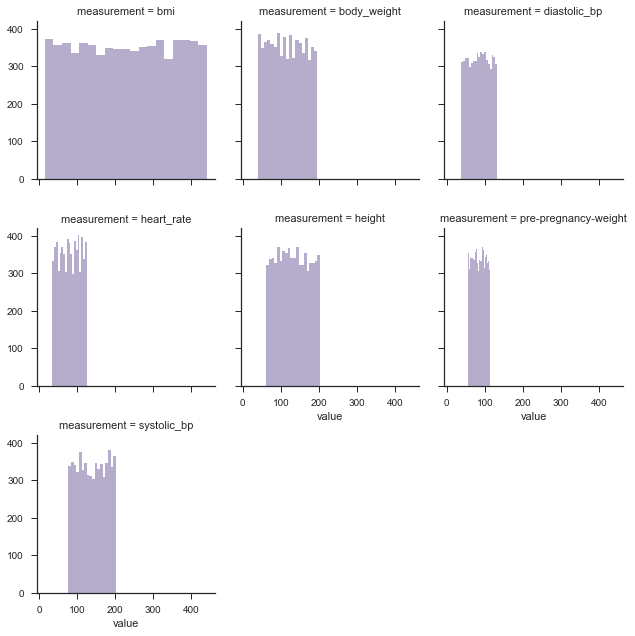

In [12]:
g = sns.FacetGrid(measurements[measurements.columns[:-1]].stack().reset_index().rename(columns={0:'value'}), col="measurement", 
                  margin_titles=True, col_wrap=3)
g.map(sns.distplot, 'value', kde=False);

Now, back to the observation dataset: we want to extract the subset of the observation data corresponding to patients with data in `measurements` table. The `isin` method checks the membership of values in one table with those in another. 

We then drop rows with missing values in the `value_source_value` column using `dropna`.

In [13]:
observation_subset = (observation_data[observation_data.person_id
                                        .isin(measurement_data.person_id)]
                                        .dropna(subset=['value_source_value']))

In [14]:
observation_subset.tail()

,observation_id,person_id,observation_concept_id,observation_date,observation_datetime,observation_type_concept_id,value_as_number,value_as_string,value_as_concept_id,qualifier_concept_id,unit_concept_id,provider_id,visit_occurrence_id,observation_source_value,observation_source_concept_id,unit_source_value,qualifier_source_value,value_source_concept_id,value_source_value,questionnaire_response_id
1192841,1214695,999647995,40768856,2017-02-19,2017-02-19 15:49:49,581413,NaN,NaN,45877994,0,0,NaN,7512.0,66174-4,40768856,NaN,NaN,45877994,LA33-6,NaN
1192842,1214696,999863749,1586218,2015-07-19,2015-07-19 16:49:46,581413,NaN,NaN,0,0,0,NaN,7513.0,heart-rhythm-status,1586218,NaN,NaN,0,irregularity-detected,NaN
1192843,1214697,999863749,1586222,2015-07-19,2015-07-19 16:49:46,581413,NaN,NaN,0,0,0,NaN,7513.0,protocol-modifications-blood-pressure,1586222,NaN,NaN,0,manual-blood-pressure,NaN
1192844,1214698,999863749,1586223,2015-07-19,2015-07-19 16:49:46,581413,NaN,NaN,0,0,0,NaN,7513.0,protocol-modifications-heart-rate,1586223,NaN,NaN,0,manual-heart-rate,NaN
1192847,1214701,999863749,40768856,2015-07-19,2015-07-19 16:49:46,581413,NaN,NaN,45877994,0,0,NaN,7513.0,66174-4,40768856,NaN,NaN,45877994,LA33-6,NaN


We will now drop duplicate values from the observation dataset, and pivot to wide format, as we did with the measurement data.

In [15]:
observation_subset = (observation_subset.drop_duplicates(subset=['person_id','observation_date'])
                .set_index(['person_id','observation_date','observation_source_value'])
                .drop_duplicates()
                .value_source_value
                .unstack(level=-1))

There are a large number of variables in the dataset with missing values. We can see what proportion of variables are missing what proportion of each column is missing using the `notnull` method, then taking the `mean` of its result.

In [16]:
observation_subset.notnull().mean().sort_values(ascending=False).head(10)

observation_source_value
ActiveDuty_AvtiveDutyServeStatus         0.201020
heart-rhythm-status                      0.169846
ExtraConsent_18YearsofAge                0.140428
OverallHealth_AverageFatigue7Days        0.109480
EHRConsentPII_AccessChangeMind           0.101460
Alcohol_6orMoreDrinksOccurence           0.094374
Alcohol_AlcoholParticipant               0.026952
ColumbiaSitePairing_ColumbiaCare         0.024940
EHRConsentPII_AccessPrivacyGuaruntee     0.018138
EastSoutheastMichigan_CareAtHenryFord    0.017118
dtype: float64

Based on this, we will take only variables with >5% non-missingness, and `join` them with measurements. Notice that the merged dataset is much smaller than the original `observations` table.

In [17]:
cols_to_keep = observation_subset.notnull().mean().sort_values(ascending=False).iloc[:5].index
merged_dataset = measurements.reset_index(level=-1).join(observation_subset[cols_to_keep].reset_index(level=-1))
merged_dataset.shape

(35285, 15)

The merged dataset now contains columns from both tables with data from the same patients.

In [18]:
merged_dataset.head()

,measurement_date,bmi,body_weight,diastolic_bp,heart_rate,height,pre-pregnancy-weight,systolic_bp,wheelchair-bound-status,observation_date,ActiveDuty_AvtiveDutyServeStatus,heart-rhythm-status,ExtraConsent_18YearsofAge,OverallHealth_AverageFatigue7Days,EHRConsentPII_AccessChangeMind
person_id,,,,,,,,,,,,,,,
100276412,2014-03-05,418.0,41.1,64.0,68.0,150.0,66.2,136.0,wheelchair-bound,2014-01-22,None,None,None,None,None
100276412,2014-03-05,418.0,41.1,64.0,68.0,150.0,66.2,136.0,wheelchair-bound,2014-01-26,None,None,None,None,AccessChangeMind_No
100276412,2014-03-05,418.0,41.1,64.0,68.0,150.0,66.2,136.0,wheelchair-bound,2014-01-29,PMI_PreferNotToAnswer,None,None,None,None
100276412,2014-03-05,418.0,41.1,64.0,68.0,150.0,66.2,136.0,wheelchair-bound,2014-03-05,None,no-irregularity-detected,None,None,None
100281317,2015-04-13,199.0,57.3,109.0,115.0,66.3,75.5,98.0,None,2015-01-18,None,None,18YearsofAge_18YearsYes,None,None


Several of the variables are **categorical**. We can transform categorical variables to numeric values, so they can be used in quantitative analyses.

Notice in each cell below, we are using the `replace` method again, along with a *lookup table* replacing text values with numeric values.

In [19]:
merged_dataset['active_duty'] = (merged_dataset.ActiveDuty_AvtiveDutyServeStatus
                                           .replace({'AvtiveDutyServeStatus_No': 0,
                                                   'AvtiveDutyServeStatus_Yes': 1,
                                                   'PMI_PreferNotToAnswer': np.nan}))

In [20]:
merged_dataset['wheelchair_bound'] = (merged_dataset['wheelchair-bound-status'].fillna(0)
                                                .replace({'wheelchair-bound':1})
                                                .astype(int))


In [21]:
merged_dataset['heart_irregularity'] = (merged_dataset['heart-rhythm-status']
                                        .replace({'no-irregularity-detected': 0,
                                                 'irregularity-detected': 1}))

In [22]:
merged_dataset['fatigue'] = (merged_dataset.OverallHealth_AverageFatigue7Days
                                .replace({'AverageFatigue7Days_None': 0,
                                         'AverageFatigue7Days_Mild': 1,
                                         'AverageFatigue7Days_Moderate': 2,
                                         'AverageFatigue7Days_Severe': 3,
                                         'AverageFatigue7Days_VerySevere': 4}))

In [23]:
merged_dataset.dropna(subset=['fatigue'], inplace=True)

## Data analysis

To perform an analysis on the dataset, we will use `scikit-learn`, a powerful package for applying machine learning algorithms to large datasets.

Using `scikit-learn`, we will use a powerful method called *random forests* to try and predict fatigue in patients from a set of variables. Specifically, we will attempt to predict moderate or worse fatigue, so we can create this variable here:

In [24]:
y = (merged_dataset.fatigue.values > 1).astype(int)

This gives us zeros or ones depending on whether the level of fatigue was moderate or greater.

Next, we extract a set of variables we feel may be predictive of fatigue. We can *index* them from the merged dataset like this:

In [25]:
X = merged_dataset[['active_duty', 'wheelchair_bound', 'heart_irregularity', 'bmi', 'body_weight',
                   'diastolic_bp', 'heart_rate', 'height', 'systolic_bp']]

Since we have *missing values*, the first step is to impute missing predictors; the missing values are all in the categorical variables, so we will impute based in the most frequent category.

The `scikit-learn` package has an `Imputer` for automatically performing the imputation using the method that we specify:

In [26]:
from sklearn.preprocessing import Imputer

value_imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X = value_imputer.fit_transform(X)

Next, we use the `RandomForestClassifier` to build a random forest for this dataset. It is called a random forest because it builds a set of decision trees using subsets of the input variables to predict the outcome. It then *averages* over these trees to make predictions. It is good at accounting for *interactions* among the predictor variables.

We first create a classifier ant `fit` it to our data.

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=4)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

After fitting, we can try and predict outcomes using the classifier. If we pass in our original data, we can see that it does rather well at recovering the true outcome:

In [28]:
preds = rf.predict(X)
pd.crosstab(y, preds, rownames=['actual'], 
            colnames=['prediction'])

prediction,0,1
actual,,
0,1533,12
1,33,2285


We can verify this using the `accuracy_score` function, which returns a high value.

In [29]:
from sklearn.metrics import accuracy_score

accuracy_score(y, preds)

0.98835102252135643

BUT, this model is *overfit* to the dataset!

If we perform *cross-validation*, which holds out part of the data, fitting the model to the rest and checking it with the hold-out dataset, we can see that the model does poorly. Only 50% accuracy on the hold-out sets!

In [30]:
from sklearn.model_selection import cross_val_score

cross_val_score(rf, X, y, n_jobs=3)

array([ 0.50931677,  0.50621118,  0.52136752])

## Conclusions

This being a randomly-generated dataset, it is not particularly useful for prediction. However, this notebook illustrates what an analytic workflow might look like for real PMI data. 

---

In [31]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()